In [ ]:

from astropy import time 
import numpy as np

from poliastro.bodies import Venus, Earth, Mars, Jupiter, Saturn, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

#from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates



# epoch1 = Time("2030-08-17 12:05:50", scale="tdb")#Start date of plot
# epoch2 = Time("2040-10-17 12:05:50", scale="tdb")#end date of plot

#epoch3 = Time("2038-11-17 12:05:50", scale="tdb")#
MinTof = 0.25 << u.year
MaxTof = 5 << u.year#maximum allowed time of flight
tejRes = 5 << u.day
tofRes = 5 << u.day




# ##find the ephemeris of earth, mars at date of launch & at date of arrival
# earth = Ephem.from_body(Earth, time_range(epoch1, end=epoch3))
# arrivalbody = Ephem.from_body(arrivalBody, time_range(epoch1, end=epoch3))
lowest_dv = 3000


def calculatePork(start_body,end_body,start_date,end_date):
    epoch_1 = start_date
    epoch_2 = end_date
    epoch_3 = epoch_2 + 1.2*MaxTof
    # current_epoch = epoch_1
    print(f"Checking over {epoch_1} to {epoch_2}")
    print(f"Looking for trajectories from {start_body} to {end_body}")
    
    rows = int((epoch_2-epoch_1)/tejRes)
    cols = int(MaxTof.to(u.day)/tofRes)
    print(f"Rows: {rows}, Cols: {cols}")

    maneuver_array = np.empty((rows, cols), dtype=object)
    dv_array = np.empty((rows, cols), dtype=int)
    date_array = np.empty((rows, cols), dtype=object)

    ##find the ephemeris of earth, mars at date of launch & at date of arrival
    start_body_ephem = Ephem.from_body(start_body, time_range(epoch_1, end=epoch_3))
    arrival_body_ephem = Ephem.from_body(end_body, time_range(epoch_1, end=epoch_3))
    lowest_dv = 4000
    for i in range(rows):
        current_epoch = epoch_1+i*tejRes
        start_body_ephem = Ephem.from_body(start_body, time_range(epoch_1, end=current_epoch))
        #find the orbit of earth & mars at launch & landing
        # Solve for departure and target orbits
        ss_earth = Orbit.from_ephem(Sun, start_body_ephem, current_epoch)
        # ss_earth=Orbit.from_body_ephem(start_body, current_epoch)

        # currentTof = 0
        for j in range(1,cols):
            currentTof = j*tofRes 
            arrivalTime = current_epoch + currentTof
            # print(arrivalTime)
            arrival_body_ephem = Ephem.from_body(end_body, time_range(current_epoch, end=arrivalTime))
            ss_arrival = Orbit.from_ephem(Sun, arrival_body_ephem, arrivalTime)

            # ss_arrival = Orbit.from_body_ephem(end_body, arrivalTime)
            # Solve for the transfer maneuver 
            man_lambert = Maneuver.lambert(ss_earth, ss_arrival,M=0)

            
            maneuver_array[i][j] = man_lambert[0]
            
            dv = np.linalg.norm(maneuver_array[i][j][1].value)
            # print(dv)
            if(dv<lowest_dv):
                        lowest_dv = dv
            dv_array[i][j] = int(dv)
            date_array[i][j] = current_epoch,arrivalTime
    print(lowest_dv)      
    return date_array,dv_array

date1 = time.Time("2025-01-01 12:05:50", scale="tdb")
date2 = time.Time("2050-01-01 12:05:50", scale="tdb")
dates,dvs = calculatePork(Earth,Saturn,date1,date2)
#print(dvs[0])


Checking over 2025-01-01 12:05:50.000 to 2050-01-01 12:05:50.000
Looking for trajectories from Earth (♁) to Saturn (♄)
Rows: 1826, Cols: 365


In [4]:
from astropy import time


In [ ]:
import csv

# Save dates to CSV
# with open("jupiter_dates.csv", "w", newline="") as f_dates:
#     writer = csv.writer(f_dates)
#     for row in dates:
#         for launch, arrival in row:
#             writer.writerow([launch.iso, arrival.iso])

# Save dvs to CSV
with open("saturn_dvs.csv", "w", newline="") as f_dvs:
    writer = csv.writer(f_dvs)
    for row in dvs:
        writer.writerow(row)

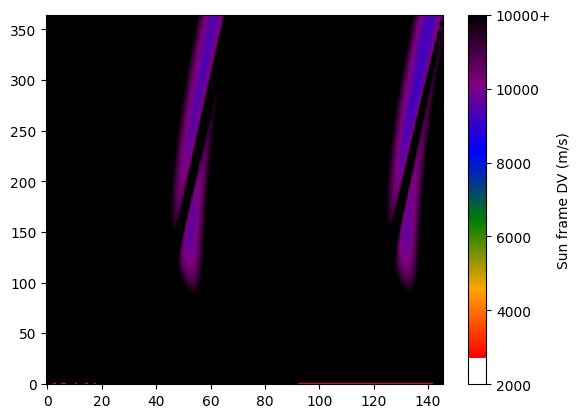

In [80]:
# Convert Astropy Time to Matplotlib dates

# #print(mdates.date2num(dates))


# start_date = mdates.date2num(dates[0][0][0].to_datetime())
# end_date = mdates.date2num(dates[-1][0][0].to_datetime())


clean_data = dvs.astype(float).transpose()
#t_time = dates[]

num_dates = 5
dates_l = np.linspace(start_date, end_date, num_dates)
date_labels = [mdates.num2date(date).strftime('%Y-%m-%d') for date in dates_l]
date_ticks = np.linspace(0, clean_data.shape[1] - 1, num_dates)
y_ticks = np.linspace(0, clean_data.shape[0] - 1, 5)  # 4 quarters + start of the year
y_labels = [clean_data.shape[0], '3 months', '6 month', '9 months', '12 months']
# Define a custom colormap from blue to red for the porkchop plot
#TBA proper coloring scheme!
#
cmap = colors.LinearSegmentedColormap.from_list("red_to_orange_to_green_to_blue_to_purple_to_black", ["red","orange","green", "blue","purple","black"])
#print(lowest_dv)
#print(y_labels)
# Create the plot
#print(dv_array[20,30])
plt.imshow(clean_data, cmap=cmap, aspect='auto', vmin=12000, vmax=lowest_dv,origin = 'lower')
# Set the x-ticks to correspond to the dates
# plt.xticks(ticks=date_ticks, labels=date_labels, rotation=45)
# plt.yticks(ticks=y_ticks, labels=y_labels)
# #plt.ylim(bottom = lowest_dv)
# #plt.title(f"Porkchop {Earth} to {arrivalBody}")
# #plt.ylabel("DV from Earth surface Sun frame")
# plt.ylabel("Time of flight")
# plt.xlabel("Date of departure")
# ax2 = plt.twinx()
# ax2.set_ylabel("DV")

# Add colorbar and label it
cbar = plt.colorbar()
cbar.set_label("Sun frame DV (m/s)")  # Replace with the appropriate label for your data
ticks = cbar.get_ticks()
#ticks[-1] = ticks[-1] + 1  # Adjust top tick
cbar.set_ticks(ticks)
tick_labels = [f"{int(t)}" for t in ticks[:-1]] + ["10000+"]  # Replace top tick label
cbar.set_ticklabels(tick_labels)

# print(dv_array[60][13])
# print(date_array[60][13])


# Add a colorbar to show the mapping from data values to colors
#plt.colorbar()

# Show the plot
plt.show()


In [35]:
from astropy.time import Time, TimeDelta
import numpy as np

from poliastro.bodies import Earth, Mars, Jupiter, Sun
from poliastro.frames import Planes
from poliastro.ephem import Ephem

from poliastro.plotting import StaticOrbitPlotter, OrbitPlotter2D
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import norm
from astropy import units as u
from poliastro.examples import molniya
from poliastro.util import time_range

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates


epoch1 = Time("2031-08-17 12:05:50", scale="tdb")
epoch2 = Time("2033-10-17 12:05:50", scale="tdb")
epoch3 = Time("2034-11-17 12:05:50", scale="tdb")
MinTof = 0.1 << u.year
MaxTof = 1 << u.year
tejRes = 5 << u.day
tofRes = 5 << u.day

rows = int((epoch2-epoch1)/tejRes)
cols = int(365*u.day/tejRes)

maneuver_array = np.empty((rows, cols), dtype=object)
dv_array = np.empty((rows, cols), dtype=object)
date_array = np.empty((rows, cols), dtype=object)

##find the ephemeris of earth, mars at date of launch & at date of arrival
earth = Ephem.from_body(Earth, time_range(epoch1, end=epoch3))
mars = Ephem.from_body(Mars, time_range(epoch1, end=epoch3))

    ###Solve lambert for iterated TEJ, TOF
current_epoch = epoch1
for i in range(rows):
    current_epoch += tejRes
    #find the orbit of earth & mars at launch & landing
    # Solve for departure and target orbits
    ss_earth = Orbit.from_ephem(Sun, earth, current_epoch)
    currentTof = 15*u.day
    arrivalTime = current_epoch + currentTof
    ss_mars = Orbit.from_ephem(Sun, mars, arrivalTime)
    # Solve for the transfer maneuver 
    man_lambert = Maneuver.lambert(ss_earth, ss_mars)
    dv = np.linalg.norm(man_lambert[0][1].value)
    #print(dv)



In [ ]:
from astropy import units as u

from poliastro.bodies import Earth, Mars
from poliastro.plotting.porkchop import PorkchopPlotter
from poliastro.util import time_range

launch_span = time_range("2005-04-30", end="2005-10-07")
arrival_span = time_range("2005-11-16", end="2006-12-21")
porkchop_plot = PorkchopPlotter(Earth, Mars, launch_span, arrival_span)
dv_dpt, dv_arr, c3dpt, c3arr, tof = porkchop_plot.porkchop()

ImportError: cannot import name 'PorkchopPlotter' from 'poliastro.plotting.porkchop' (c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\plotting\porkchop.py)

<class 'numpy.ndarray'>


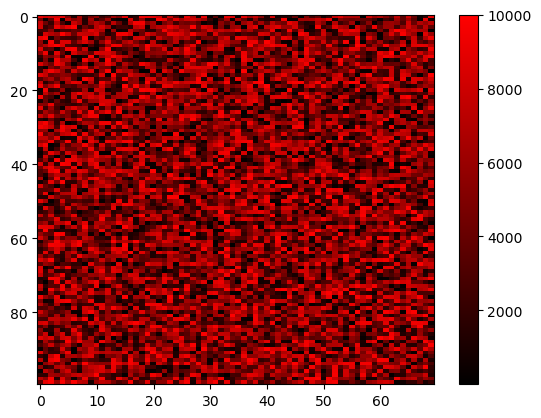

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Create a sample 2D array (100x70)
data = np.random.randint(0, 10001, (100, 70))
print(type(data))
# Define a custom colormap from black to red
cmap = colors.LinearSegmentedColormap.from_list("black_to_red", ["black", "red"])

# Create the plot
plt.imshow(data, cmap=cmap, aspect='auto')

# Add a colorbar to show the mapping from data values to colors
plt.colorbar()

# Show the plot
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from astropy.coordinates import solar_system_ephemeris
from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth, Moon
from poliastro.constants import rho0_earth, H0_earth

from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    third_body,
    J2_perturbation,
)
from poliastro.core.propagation import func_twobody
from poliastro.ephem import build_ephem_interpolant
from poliastro.plotting import OrbitPlotter3D
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"
from poliastro.twobody.events import LithobrakeEvent

R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value

alt = 150

orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m**2) / (100 * u.kg)).to_value(
    u.km**2 / u.kg
)  # km^2/kg
B = C_D * A_over_m

# parameters of the atmosphere
rho0 = rho0_earth.to(u.kg / u.km**3).value  # kg/km^3
H0 = H0_earth.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 100000 * u.s, num=2000))


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = atmospheric_drag_exponential(
        t0,
        state,
        k,
        R=R,
        C_D=C_D,
        A_over_m=A_over_m,
        H0=H0,
        rho0=rho0,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


rr, _ = orbit.to_ephem(
    EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f)),
).rv()

plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, norm(rr, axis=1) - Earth.R)


orbit = Orbit.circular(
    Earth, alt * u.km, epoch=Time(0.0, format="jd", scale="tdb")
)
tofs = TimeDelta(np.linspace(0 * u.h, 100 * u.d, num=2000))

lithobrake_event = LithobrakeEvent(R)
events = [lithobrake_event]

rr, _ = orbit.to_ephem(
    EpochsArray(
        orbit.epoch + tofs, method=CowellPropagator(f=f, events=events)
    ),
).rv()

print(
    "orbital decay seen after", lithobrake_event.last_t.to(u.d).value, "days"
)
plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs[: len(rr)].value, norm(rr, axis=1) - Earth.R)

ImportError: cannot import name 'EpochsArray' from 'poliastro.twobody.sampling' (c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\twobody\sampling.py)

In [ ]:
from astropy import units as u

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver

# Data for Mars at J2000 from JPL HORIZONS
a = 1.523679 << u.AU
ecc = 0.093315 << u.one
inc = 1.85 << u.deg
raan = 49.562 << u.deg
argp = 286.537 << u.deg
nu = 23.33 << u.deg

orb = Orbit.from_classical(Sun, a, ecc, inc, raan, argp, nu)
orb.plot()

In [ ]:
orb_i = Orbit.circular(Earth, alt=700 << u.km)
# orb_i
# 7078 x 7078 km x 0.0 deg (GCRS) orbit around Earth (♁)
orb_i.plot()
hoh = Maneuver.hohmann(orb_i, 36000 << u.km)
hoh.get_total_cost()
# <Quantity 3.6173981270031357 km / s>
hoh.get_total_time()
# <Quantity 15729.741535747102 s>
orb_f=orb_i.apply_maneuver(hoh)
orb_f.plot()

In [ ]:
from poliastro.plotting import OrbitPlotter

op = OrbitPlotter(backend_name="matplotlib2D")
orb_a, orb_f = orb_i.apply_maneuver(hoh, intermediate=True)
op.plot(orb_i, label="Initial orbit")
op.plot(orb_a, label="Transfer orbit")
op.plot(orb_f, label="Final orbit")
op.show()

In [ ]:
import numpy as np

import astropy.units as u
from astropy import time

from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from poliastro.plotting import OrbitPlotter3D
